In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc 
import math as Math
import keras 
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.utils.vis_utils import plot_model
from keras.layers import Bidirectional
from keras.utils.generic_utils import get_custom_objects
import random
import os


seed = 1024
def reset_random_seeds():
   print("resetting seeds")
   os.environ['PYTHONHASHSEED']=str(seed)
   tensorflow.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds()


#Supressing Warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

path = '/content/drive/My Drive/LandfallAAAISubmission/' # Path of file
filePath = path + 'IMDDataTillLandfall.csv'
data = pd.read_csv(filePath, index_col=0)

faniData = data[data['cyclone_id'].str.contains('2019-2')]
print('faniData Shape', faniData.shape)
bulbulData = data[data['cyclone_id'].str.contains('2019-9')]
print('bulbulData Shape', bulbulData.shape)
gajaData = data[data['cyclone_id'].str.contains('2018-13')]
print('gajaData Shape', gajaData.shape)

#Removing Fani, Bulbul, Gaja data from dataset
data = data[~data['cyclone_id'].str.contains('2019_2')]
data = data[~data['cyclone_id'].str.contains('2019_9')]
data = data[~data['cyclone_id'].str.contains('2018_13')]

print('data  Shape', data.shape)


#Normalizing features
scalers = {}
columnsToNormalize = ['ecp','sst','distance','direction','mssw','lati','long']

for col in columnsToNormalize:
  scaler = StandardScaler()
  data[[col]] = scaler.fit_transform(data[[col]])
  scalers[col] =  scaler

data_pad = []

for key in np.unique(data['cyclone_id']):
    data_pad += [data[ data.loc[:, 'cyclone_id'] == key].loc[:, ['ecp','sst','distance','direction','mssw','lati','long']].values]

#Normalizing the features of Fani, Gaja, Bulbul with same scalers
for col in columnsToNormalize:
  scaler = scalers[col]
  faniData[[col]] = scaler.transform(faniData[[col]])

data_padF = []
data_padF += [faniData.loc[:, ['ecp','sst','distance','direction','mssw','lati','long']].values]

for col in columnsToNormalize:
  scaler = scalers[col]
  bulbulData[[col]] = scaler.transform(bulbulData[[col]])

data_padB = []
data_padB += [bulbulData.loc[:, ['ecp','sst','distance','direction','mssw','lati','long']].values]


for col in columnsToNormalize:
  scaler = scalers[col]
  gajaData[[col]] = scaler.transform(gajaData[[col]])

data_padG = []
data_padG += [gajaData.loc[:, ['ecp','sst','distance','direction','mssw','lati','long']].values]


#Preapring training dataset
def load_data(data_pad, trainPoints ,amount_of_features):
    X = []
    y = []
    for cdata in data_pad:
      length = len(cdata)
      diff = length - trainPoints
      if diff > 0:
        yy = cdata[length-1][[-2, -1]]
        for i in range(diff):
          cc = cdata[i : i + trainPoints]
          X.append(cc)
          y.append(yy)
    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], amount_of_features)) 
    #y_train = np.reshape(y, (y.shape[0], y.shape[1], 1))
    return [x_train, y]

#Model Definition
def build_model(feature_count, trainPoints):
    noOfPredFeatures = 2
    model = Sequential()
    model.add(Bidirectional(LSTM(1024, activation='relu', return_sequences=True, input_shape=(trainPoints, feature_count))))
    model.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=False)))
    model.add(Dense(noOfPredFeatures))
    model.compile(loss="mse", optimizer="adam")
    return model

feature_count = 7
trains = [4, 6, 8, 12]

resetting seeds
faniData Shape (58, 8)
bulbulData Shape (47, 8)
gajaData Shape (59, 8)
data  Shape (3988, 8)


In [ ]:
def getMaeRmse(predictions, y_test, scalers):
  length = len(predictions)
  latiScaler = scalers['lati']
  longScaler = scalers['long']
  #Extracting predicted and acutal latis
  latisP = predictions[:,0]
  longsP = predictions[:,1]
  latisA = y_test[:,0]
  longsA = y_test[:,1]

  latisA = np.reshape(latisA,(length,1))
  longsA = np.reshape(longsA,(length,1))
  latisP = np.reshape(latisP,(length,1))
  longsP = np.reshape(longsP,(length,1))

  #Getting actual values of latitiude/longitude
  latisA = latiScaler.inverse_transform(latisA)
  longsA = longScaler.inverse_transform(longsA)
  latisP = latiScaler.inverse_transform(latisP)
  longsP = longScaler.inverse_transform(longsP)

  testScorela = mean_squared_error(latisA, latisP)
  testScorelo = mean_squared_error(longsA, longsP)

  testScorelaMae = mean_absolute_error(latisA, latisP)
  testScoreloMae = mean_absolute_error(longsA, longsP)

  return np.sqrt(testScorela), np.sqrt(testScorelo), testScorelaMae, testScoreloMae


In [ ]:
def getDistance(predictions, y_test, scalers):
  length = len(predictions)
  latiScaler = scalers['lati']
  longScaler = scalers['long']
  latisP = predictions[:,0]
  longsP = predictions[:,1]
  latisA = y_test[:,0]
  longsA = y_test[:,1]

  latisA = np.reshape(latisA,(length,1))
  longsA = np.reshape(longsA,(length,1))
  latisP = np.reshape(latisP,(length,1))
  longsP = np.reshape(longsP,(length,1))

  latisA = latiScaler.inverse_transform(latisA)
  longsA = longScaler.inverse_transform(longsA)
  latisP = latiScaler.inverse_transform(latisP)
  longsP = longScaler.inverse_transform(longsP)
  dist = 0
  distM = 0
  for i in range(length):
    actualCor = [latisA[i][0], longsA[i][0]]
    predictedCor = [latisP[i][0], longsP[i][0]]
    dist = dist + vc(actualCor, predictedCor).kilometers
    distM = distM + vc(actualCor, predictedCor).miles

  return dist/length, distM/length


In [ ]:
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("T (sizeo of training point) =   ", trainPoints)
  X, y = load_data(data_pad, trainPoints, feature_count)
  XF, yF = load_data(data_padF, trainPoints, feature_count)
  XG, yG = load_data(data_padG, trainPoints, feature_count)
  XB, yB = load_data(data_padB, trainPoints, feature_count)

  X, y = shuffle(X, y, random_state=seed)

  print("No of train points", X.shape)

  kf = KFold(n_splits=5, shuffle=True,  random_state=seed)

  scoresla = []
  scoresFla = []
  scoresGla = []
  scoresBla = []

  scoreslaMae = []
  scoresFlaMae = []
  scoresGlaMae = []
  scoresBlaMae = []
    
  scoreslo = []
  scoresFlo = []
  scoresGlo = []
  scoresBlo = []

  scoresloMae = []
  scoresFloMae = []
  scoresGloMae = []
  scoresBloMae = []

  scoresMi = []
  scoresFMi = []
  scoresGMi = []
  scoresBMi = []

  scoresKm = []
  scoresFKm = []
  scoresGKm = []
  scoresBKm = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]

      model = build_model(feature_count, trainPoints)
      model.fit(X_train, y_train, batch_size=512, epochs=150, validation_data=(X_test, y_test), verbose=0, shuffle = True)
      predictions = model.predict(X_test)
      predictionsF = model.predict(XF)
      predictionsG = model.predict(XG)
      predictionsB = model.predict(XB)

      rmsela, rmselo, msela, mselo = getMaeRmse(predictions, y_test, scalers)
      rmselaF, rmseloF, mselaF, mseloF = getMaeRmse(predictionsF, yF, scalers)
      rmselaG, rmseloG, mselaG, mseloG = getMaeRmse(predictionsG, yG, scalers)
      rmselaB, rmseloB, mselaB, mseloB = getMaeRmse(predictionsB, yB, scalers)

      distKm, distMi = getDistance(predictions, y_test, scalers)
      distKmF, distMiF = getDistance(predictionsF, yF, scalers)
      distKmG, distMiG = getDistance(predictionsG, yG, scalers)
      distKmB, distMiB = getDistance(predictionsB, yB, scalers)

      scoresMi.append(distMi)
      scoresFMi.append(distMiF)
      scoresGMi.append(distMiG)
      scoresBMi.append(distMiB)

      scoresKm.append(distKm)
      scoresFKm.append(distKmF)
      scoresGKm.append(distKmG)
      scoresBKm.append(distKmB)

      scoresla.append(rmsela)
      scoresFla.append(rmselaF)
      scoresGla.append(rmselaG)
      scoresBla.append(rmselaB)
    
      scoreslo.append(rmselo)
      scoresFlo.append(rmseloF)
      scoresGlo.append(rmseloG)
      scoresBlo.append(rmseloB)

      scoreslaMae.append(msela)
      scoresFlaMae.append(mselaF)
      scoresGlaMae.append(mselaG)
      scoresBlaMae.append(mselaB)
    
      scoresloMae.append(mselo)
      scoresFloMae.append(mseloF)
      scoresGloMae.append(mseloG)
      scoresBloMae.append(mseloB)

      print('scores latitude  RMSE ', scoresla)
      print('scores longitude  RMSE', scoreslo)
    
      print('scores latitude Mae ', scoreslaMae)
      print('scores longitude  Mae', scoresloMae)

      print('distance Miles  ', scoresMi)
      print('distances KiloMeters  ', scoresKm)

  print("5 fold accuracy Lati RMSE ",np.array(scoresla).mean())
  print("5 fold accuracy Lati Fani RMSE ", np.array(scoresFla).mean())
  print("5 fold accuracy Lati Gaja RMSE ", np.array(scoresGla).mean())
  print("5 fold accuracy Lati Bulbul RMSE ", np.array(scoresBla).mean())
    
  print("5 fold accuracy Long RMSE ",np.array(scoreslo).mean())
  print("5 fold accuracy Long Fani RMSE ", np.array(scoresFlo).mean())
  print("5 fold accuracy Long Gaja RMSE ", np.array(scoresGlo).mean())
  print("5 fold accuracy Long Bulbul RMSE ", np.array(scoresBlo).mean())

  print("5 fold accuracy  Lati MAE",np.array(scoreslaMae).mean())
  print("5 fold accuracy  Lati  Fani MAE", np.array(scoresFlaMae).mean())
  print("5 fold accuracy  Lati Gaja  MAE", np.array(scoresGlaMae).mean())
  print("5 fold accuracy  Lati Bulbul MAE", np.array(scoresBlaMae).mean())
    
  print("5 fold accuracy Long MAE",np.array(scoresloMae).mean())
  print("5 fold accuracy  Long  Fani MAE", np.array(scoresFloMae).mean())
  print("5 fold accuracy  Lati  Gaja MAE", np.array(scoresGloMae).mean())
  print("5 fold accuracy  Lati  Bulbul MAE", np.array(scoresBloMae).mean())

  # print("5 fold distance average Miles ",np.array(scoresMi).mean())
  # print("Fani average error Miles ", np.array(scoresFMi).mean())
  # print("Gaja average error Miles ", np.array(scoresGMi).mean())
  # print("Bulbul average error Miles ", np.array(scoresBMi).mean())

  print("5 fold distance average Kilometers ",np.array(scoresKm).mean())
  print("5 fold distance average Fani Kilometers ", np.array(scoresFKm).mean())
  print("5 fold distance average Gaja Kilometers ", np.array(scoresGKm).mean())
  print("5 fold distance average Bulbul Kilometers ", np.array(scoresBKm).mean())


T (sizeo of training point) =    4
No of train points (3189, 4, 7)
scores latitude  RMSE  [0.8355861777411505]
scores longitude  RMSE [1.3754491882573179]
scores latitude Mae  [0.42477512162307207]
scores longitude  Mae [0.7000615421881123]
distance Miles   [58.270690680476875]
distances KiloMeters   [93.77758642248139]
scores latitude  RMSE  [0.8355861777411505, 1.0395251566020831]
scores longitude  RMSE [1.3754491882573179, 1.588207862615241]
scores latitude Mae  [0.42477512162307207, 0.5116511958669345]
scores longitude  Mae [0.7000615421881123, 0.7653821678520372]
distance Miles   [58.270690680476875, 65.78485083312442]
distances KiloMeters   [93.77758642248139, 105.87045497918373]
scores latitude  RMSE  [0.8355861777411505, 1.0395251566020831, 1.0009466196721044]
scores longitude  RMSE [1.3754491882573179, 1.588207862615241, 1.2977466146648928]
scores latitude Mae  [0.42477512162307207, 0.5116511958669345, 0.525669307977802]
scores longitude  Mae [0.7000615421881123, 0.76538216785

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generateing latitiude/longitude grpahs for Fani, Gaja and Bulbul
trainPoints = 8  # Graphs for T = 8
X, y = load_data(data_pad, trainPoints, feature_count)
XF, yF = load_data(data_padF, trainPoints, feature_count)
XG, yG = load_data(data_padG, trainPoints, feature_count)
XB, yB = load_data(data_padB, trainPoints, feature_count)
X, y = shuffle(X, y, random_state=seed)
model = build_model(feature_count, trainPoints)
model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
predictionsF = model.predict(XF)
predictionsG = model.predict(XG)
predictionsB = model.predict(XB)

trainPoints  (T) =  8


<Figure size 720x720 with 0 Axes>

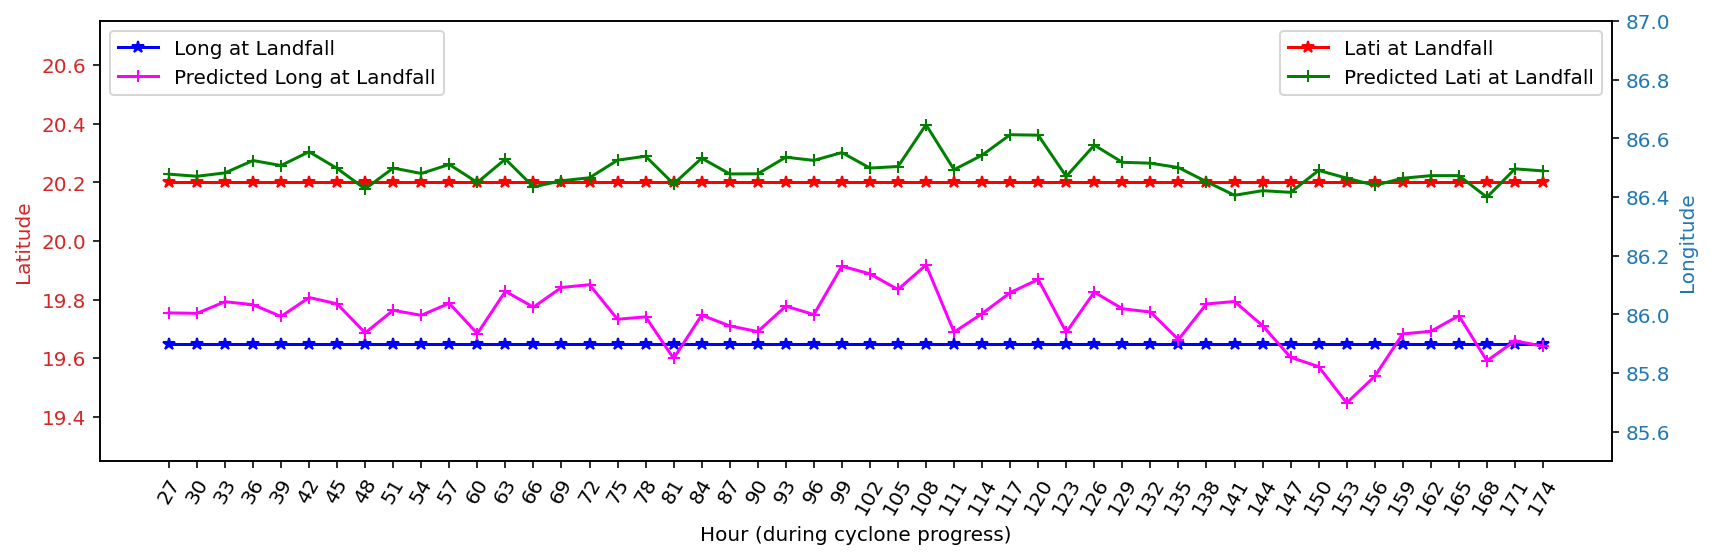

In [ ]:
# For Fani cyclone
print("trainPoints  (T) = ", trainPoints)
latiScaler = scalers['lati']
longScaler = scalers['long']

lengthF = len(yF)

latisPF = predictionsF[:,0]
longsPF = predictionsF[:,1]
latisAF = yF[:,0]
longsAF = yF[:,1]


latisPF = np.reshape(latisPF,(lengthF,1))
longsPF = np.reshape(longsPF,(lengthF,1))
latisAF = np.reshape(latisAF,(lengthF,1))
longsAF = np.reshape(longsAF,(lengthF,1))

latisPF = latiScaler.inverse_transform(latisPF)
longsPF = longScaler.inverse_transform(longsPF)
latisAF = latiScaler.inverse_transform(latisAF)
longsAF = longScaler.inverse_transform(longsAF)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthF,lengthF)*3 + 8*3
color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Latitude', color=color)
ax1.plot(a, latisAF, marker = '*',label = "Lati at Landfall",color = 'red')
ax1.plot(a, latisPF, marker = '+',label = "Predicted Lati at Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((19.25,20.75))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Longitude', color=color)  # we already handled the x-label with ax1
ax2.plot(a, longsAF, marker = '*',label = "Long at Landfall",color = 'blue')
ax2.plot(a, longsPF, marker = '+',label = "Predicted Long at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((85.5,87))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=2)
plt.show()

trainPoints   8


<Figure size 1080x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

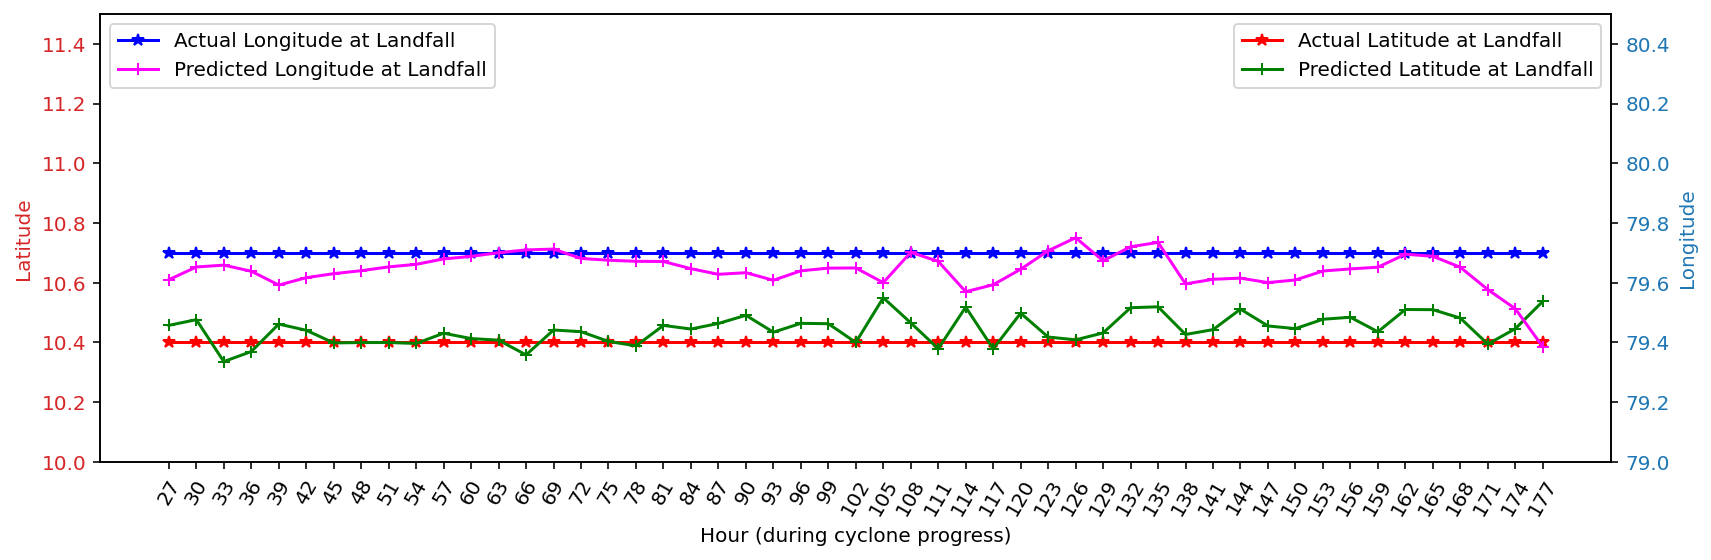

In [ ]:
# For Gaja cyclone
plt.figure(figsize=(15, 10))
print("trainPoints  ", trainPoints)
latiScaler = scalers['lati']
longScaler = scalers['long']

lengthG = len(yG)

latisPG = predictionsG[:,0]
longsPG = predictionsG[:,1]
latisAG = yG[:,0]
longsAG = yG[:,1]

latisPG = np.reshape(latisPG,(lengthG,1))
longsPG = np.reshape(longsPG,(lengthG,1))
latisAG = np.reshape(latisAG,(lengthG,1))
longsAG = np.reshape(longsAG,(lengthG,1))

latisPG = latiScaler.inverse_transform(latisPG)
longsPG = longScaler.inverse_transform(longsPG)
latisAG = latiScaler.inverse_transform(latisAG)
longsAG = longScaler.inverse_transform(longsAG)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthG,lengthG)*3 + 8*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Latitude', color=color)
ax1.plot(a, latisAG, marker = '*',label = "Actual Latitude at Landfall",color = 'red')
ax1.plot(a, latisPG, marker = '+',label = "Predicted Latitude at Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((10,11.5))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Longitude', color=color)  # we already handled the x-label with ax1
ax2.plot(a, longsAG, marker = '*',label = "Actual Longitude at Landfall",color = 'blue')
ax2.plot(a, longsPG, marker = '+',label = "Predicted Longitude at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((79,80.50))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=2)
plt.show()

trainPoints (T)   8


<Figure size 1080x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

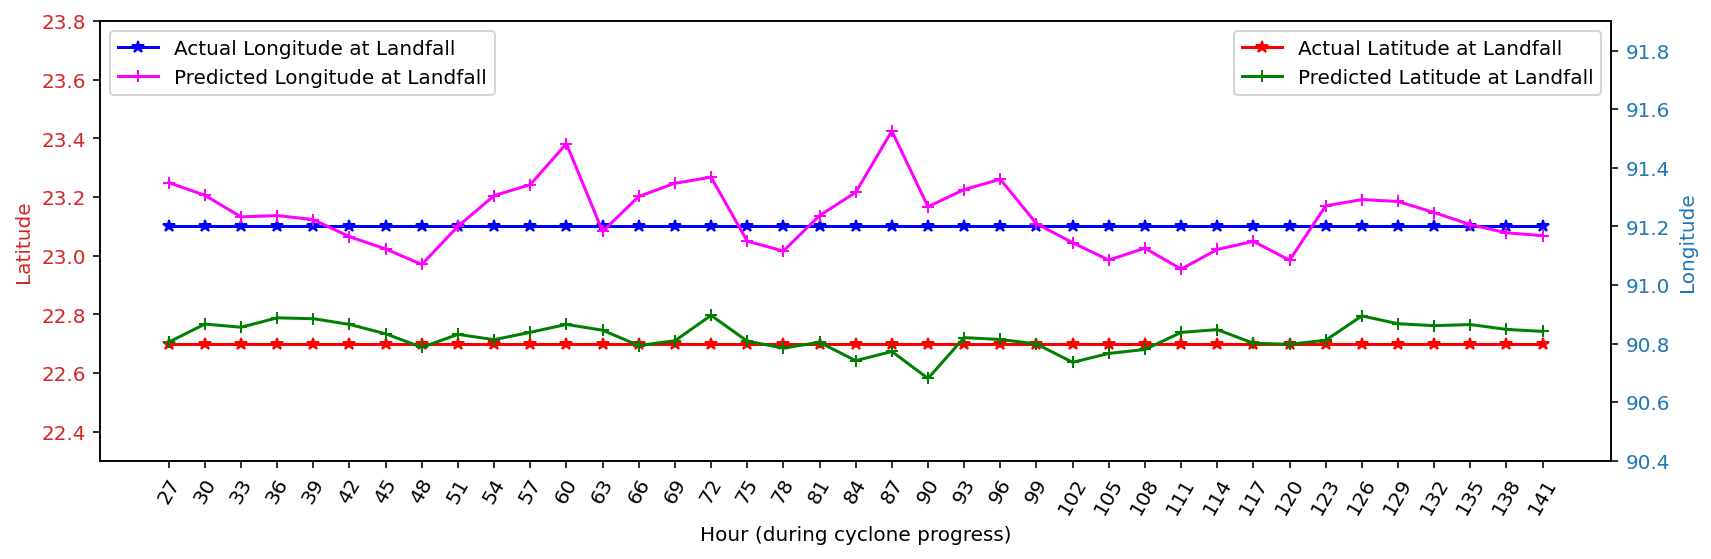

In [ ]:
# For bulbul cyclone
plt.figure(figsize=(15, 10))
print("trainPoints (T)  ", trainPoints)
latiScaler = scalers['lati']
longScaler = scalers['long']

lengthF = len(yF)
lengthG = len(yG)
lengthB = len(yB)

latisPF = predictionsF[:,0]
longsPF = predictionsF[:,1]
latisAF = yF[:,0]
longsAF = yF[:,1]

latisPG = predictionsG[:,0]
longsPG = predictionsG[:,1]
latisAG = yG[:,0]
longsAG = yG[:,1]

latisPB = predictionsB[:,0]
longsPB = predictionsB[:,1]
latisAB = yB[:,0]
longsAB = yB[:,1]


latisPB = np.reshape(latisPB,(lengthB,1))
longsPB = np.reshape(longsPB,(lengthB,1))
latisAB = np.reshape(latisAB,(lengthB,1))
longsAB = np.reshape(longsAB,(lengthB,1))

latisPB = latiScaler.inverse_transform(latisPB)
longsPB = longScaler.inverse_transform(longsPB)
latisAB = latiScaler.inverse_transform(latisAB)
longsAB = longScaler.inverse_transform(longsAB)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthB,lengthB)*3 + 8*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Latitude', color=color)
ax1.plot(a, latisAB, marker = '*',label = "Actual Latitude at Landfall",color = 'red')
ax1.plot(a, latisPB, marker = '+',label = "Predicted Latitude at Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((22.3,23.8))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Longitude', color=color)  # we already handled the x-label with ax1
ax2.plot(a, longsAB, marker = '*',label = "Actual Longitude at Landfall",color = 'blue')
ax2.plot(a, longsPB, marker = '+',label = "Predicted Longitude at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((90.4,91.90))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=2)
plt.show()

In [ ]:
#Time to calculate 150 epochs
X, y = load_data(data_pad, 4, feature_count)
X, y = shuffle(X, y, random_state=0)
model = build_model(feature_count, 4)
start = time.time()
model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
end = time.time()
print("time (seconds) ", end-start)

time (seconds)  91.82479214668274


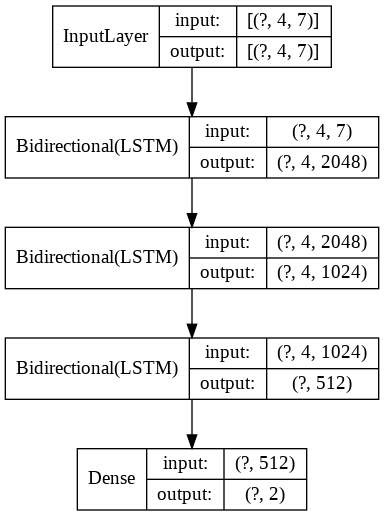

In [ ]:
#Plotting the Model structure
model = build_model(feature_count, 4)
X, y = load_data(data_pad, 4, feature_count)
model.fit(X, y, batch_size=512, epochs=10, verbose=0, shuffle = True)
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=False)